In [11]:
import os
from PIL import Image
import json
from torchvision.models import resnet50
from torchvision import transforms
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
import shutil  
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import json
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np

# Function to load images
def load_images_from_directory(root_path: str):
    dataset = []
    for label in os.listdir(root_path):
        label_path = os.path.join(root_path, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = Image.open(image_path)
                    dataset.append((img, label, image_file))
    return dataset

current_dir = "/home/z/Music/code/CAIN"
#dataset_path = f"{current_dir}/imagenet/val_images10k"

dataset_paths = [
    f"{current_dir}/imagenet/val_images10k",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/1",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/2",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/3",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/1",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/2",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/3", 
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/1",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/2",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/3",
]

for dataset_path in dataset_paths:
    
    dataset = load_images_from_directory(dataset_path)

    # Load ImageNet class index
    with open(f"{current_dir}/imagenet/imagenet_class_index.json", "r") as f:
        imagenet_class_index = json.load(f)

    # Determine device
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA!")
    else:
        device = torch.device("cpu")
        print("Using CPU!")

    label_to_index_description = {v[0]: (k, v[1]) for k, v in imagenet_class_index.items()}

    # Initialize the model
    model = resnet50(pretrained=True).to(device)
    model.eval()
    model_name = model.__class__.__name__



    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])


    def ensure_rgb(img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

    true_labels = []
    predicted_labels = []

    # Create the target directory if it does not exist
    target_dir = dataset_path + "_" + model_name
    os.makedirs(target_dir, exist_ok=True)

    for img, label, filename in tqdm(dataset):
        img = img.resize((224, 224))  # Resize to match ResNet's expected input size
        img = ensure_rgb(img)  # Ensure the image has 3 channels
        img_tensor = transform(img).to(device)
        
        # Model prediction
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0))
            predicted_label = torch.argmax(logits, dim=1).item()
        
        # Get true label
        index_str, _ = label_to_index_description.get(label, (None, None))
        if index_str is None:
            continue
        true_label = int(index_str)
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
        # If prediction is correct, copy the image to the target directory
        # if true_label == predicted_label:
        #     source_path = os.path.join(dataset_path, label, filename)
        #     target_label_dir = os.path.join(target_dir, label)
        #     os.makedirs(target_label_dir, exist_ok=True)  # Make sure the directory exists
        #     shutil.copy(source_path, target_label_dir)  # Copy the file



    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


    for target_class in set(true_labels):
        # Use sklearn's confusion matrix
        matrix = confusion_matrix(true_labels, predicted_labels, labels=[target_class])
        if matrix.size == 1:
            value = matrix[0][0]
            if target_class in predicted_labels:  # It was predicted at least once
                tp = value
                tn, fp, fn = 0, 0, 0
            else:  # It was never predicted
                tn = value
                tp, fp, fn = 0, 0, 0
        else:
            tn, fp, fn, tp = matrix.ravel()
        
        print(f"For class {target_class}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")


    dataset_name = os.path.basename(dataset_path)

    # Prepare the metrics filename with the model name and dataset name
    metrics_filename = f"{model_name}_{dataset_name}.txt"
    metrics_path = os.path.join(os.path.dirname(dataset_path), metrics_filename)
    with open(metrics_path, "w") as f:
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n")

        for target_class in sorted(set(true_labels)):
            matrix = confusion_matrix(true_labels, predicted_labels, labels=[target_class])
            if matrix.size == 1:
                value = matrix[0][0]
                if target_class in predicted_labels:  # It was predicted at least once
                    tp = value
                    tn, fp, fn = 0, 0, 0
                else:  # It was never predicted
                    tn = value
                    tp, fp, fn = 0, 0, 0
            else:
                tn, fp, fn, tp = matrix.ravel() if matrix.size == 4 else (0, 0, 0, matrix[0][0])
            # Now we append the confusion matrix for each class to the file
            f.write(f"Class {target_class} - TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}\n")

    print(f"Metrics saved to {metrics_path}")

Using CUDA!


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [01:43<00:00, 96.44it/s]


Precision: 0.7475
Recall: 0.7475
F1 Score: 0.7475
For class 0: TP=8, FP=0, FN=0, TN=0
For class 1: TP=8, FP=0, FN=0, TN=0
For class 2: TP=9, FP=0, FN=0, TN=0
For class 3: TP=6, FP=0, FN=0, TN=0
For class 4: TP=7, FP=0, FN=0, TN=0
For class 5: TP=8, FP=0, FN=0, TN=0
For class 6: TP=8, FP=0, FN=0, TN=0
For class 7: TP=7, FP=0, FN=0, TN=0
For class 8: TP=8, FP=0, FN=0, TN=0
For class 9: TP=9, FP=0, FN=0, TN=0
For class 10: TP=9, FP=0, FN=0, TN=0
For class 11: TP=10, FP=0, FN=0, TN=0
For class 12: TP=10, FP=0, FN=0, TN=0
For class 13: TP=9, FP=0, FN=0, TN=0
For class 14: TP=8, FP=0, FN=0, TN=0
For class 15: TP=9, FP=0, FN=0, TN=0
For class 16: TP=8, FP=0, FN=0, TN=0
For class 17: TP=10, FP=0, FN=0, TN=0
For class 18: TP=9, FP=0, FN=0, TN=0
For class 19: TP=9, FP=0, FN=0, TN=0
For class 20: TP=9, FP=0, FN=0, TN=0
For class 21: TP=7, FP=0, FN=0, TN=0
For class 22: TP=10, FP=0, FN=0, TN=0
For class 23: TP=10, FP=0, FN=0, TN=0
For class 24: TP=10, FP=0, FN=0, TN=0
For class 25: TP=9, FP=0, FN=

NameError: name 'predicted_scores' is not defined

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using: cuda


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [01:35<00:00, 104.78it/s]


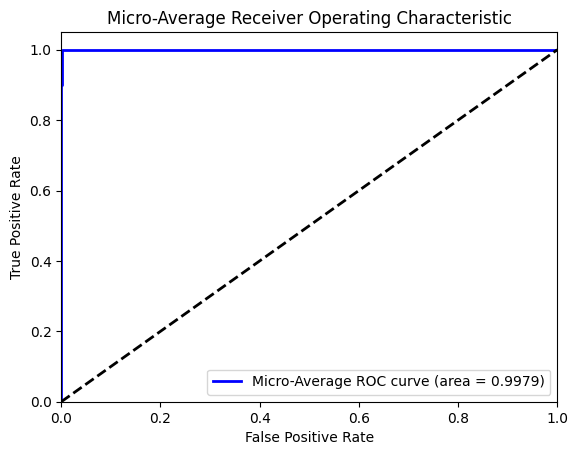

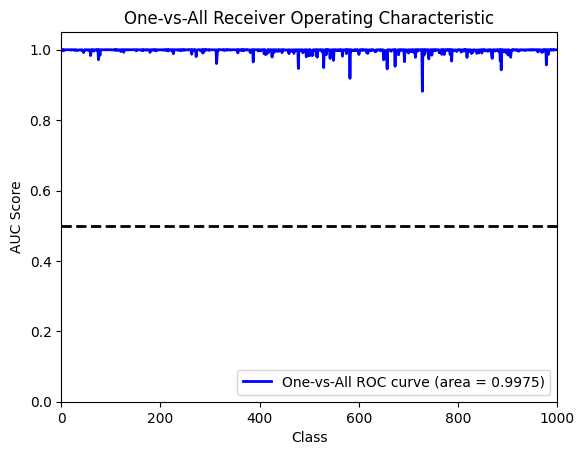

Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_ResNet50/ResNet50_val_images10k_metrics.txt
Using: cuda


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [01:03<00:00, 156.28it/s]


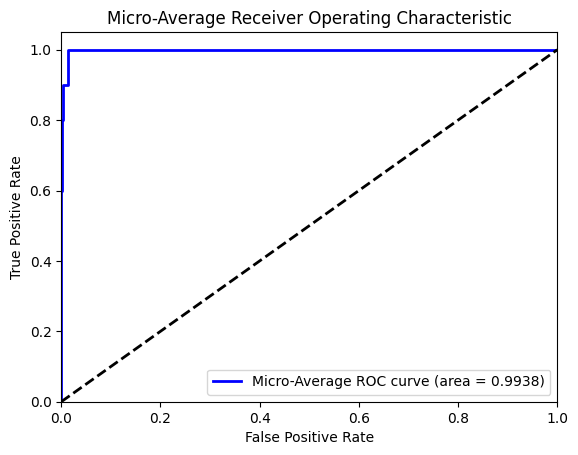

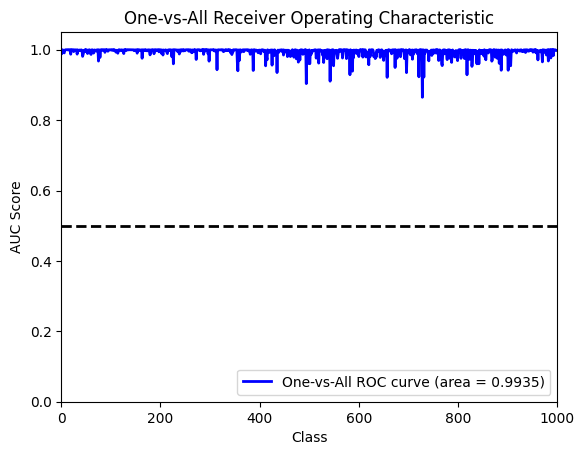

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-S statistic for 1: 0.18920
Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_attack/gaussian_noise/1_ResNet50/ResNet50_1_metrics.txt
Using: cuda


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [01:02<00:00, 160.27it/s]


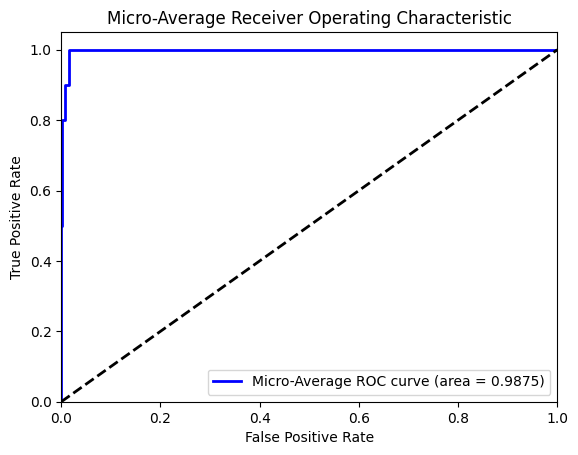

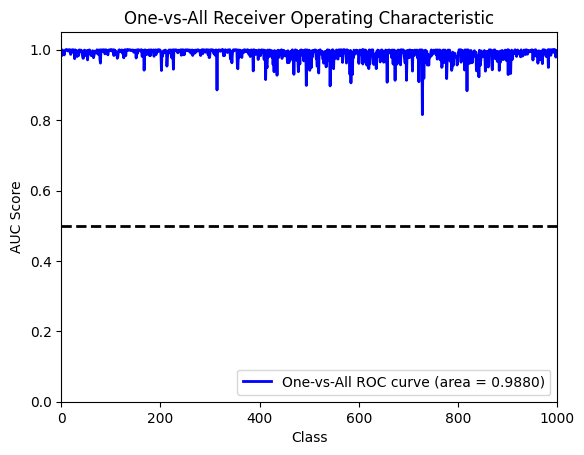

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-S statistic for 2: 0.28910
Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_attack/gaussian_noise/2_ResNet50/ResNet50_2_metrics.txt
Using: cuda


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [01:03<00:00, 157.78it/s]


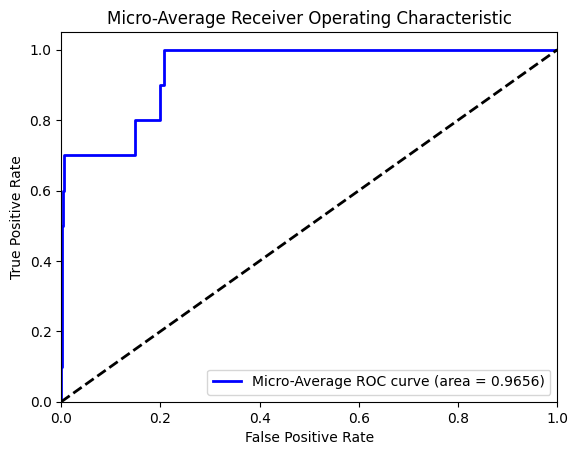

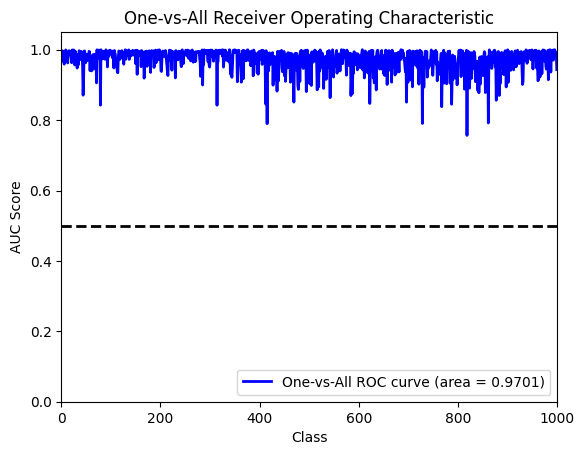

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-S statistic for 3: 0.44830
Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_attack/gaussian_noise/3_ResNet50/ResNet50_3_metrics.txt
Using: cuda


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:58<00:00, 170.45it/s]


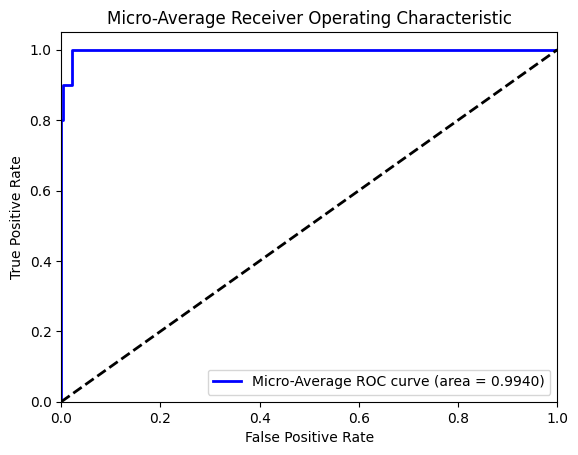

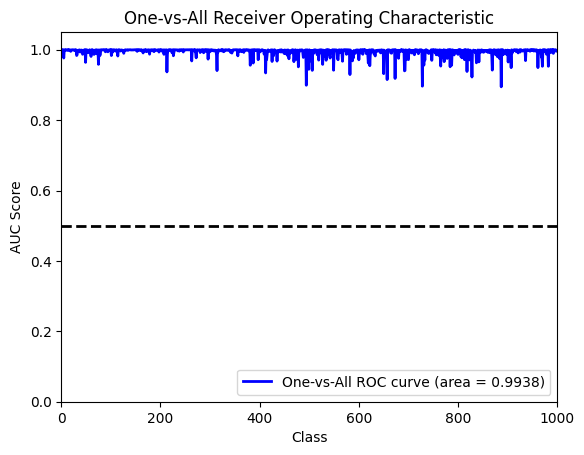

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-S statistic for 1: 0.23740
Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_attack/defocus_blur/1_ResNet50/ResNet50_1_metrics.txt
Using: cuda


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:57<00:00, 172.65it/s]


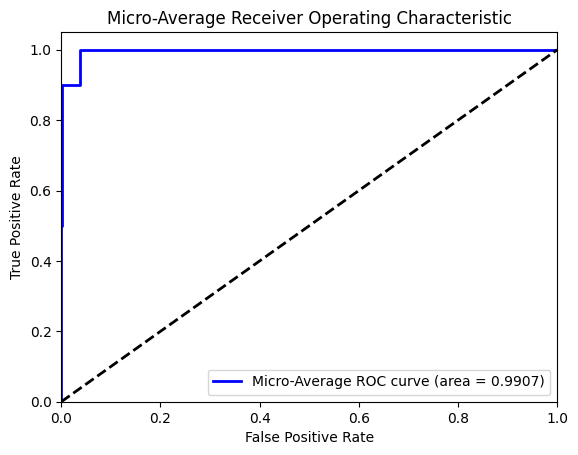

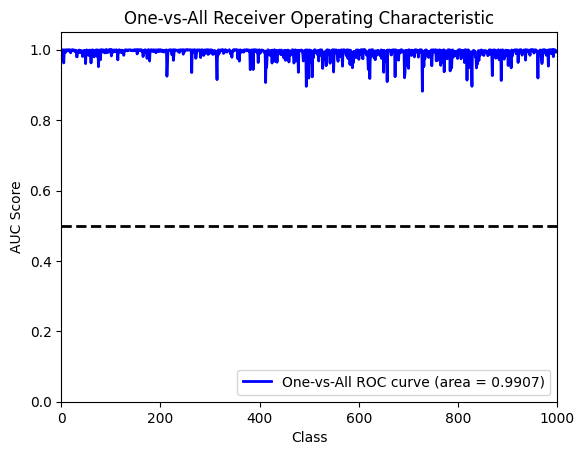

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-S statistic for 2: 0.31810
Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_attack/defocus_blur/2_ResNet50/ResNet50_2_metrics.txt
Using: cuda


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:58<00:00, 171.19it/s]


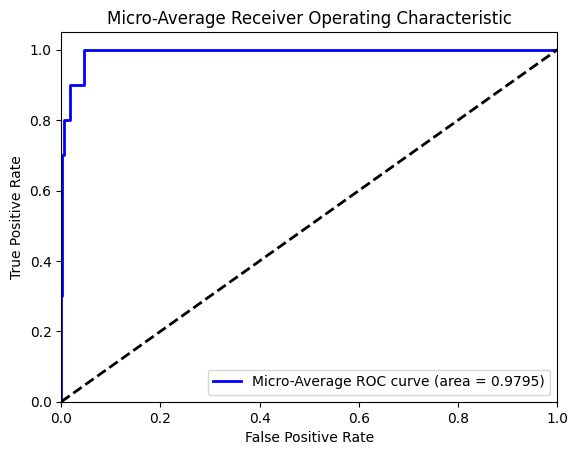

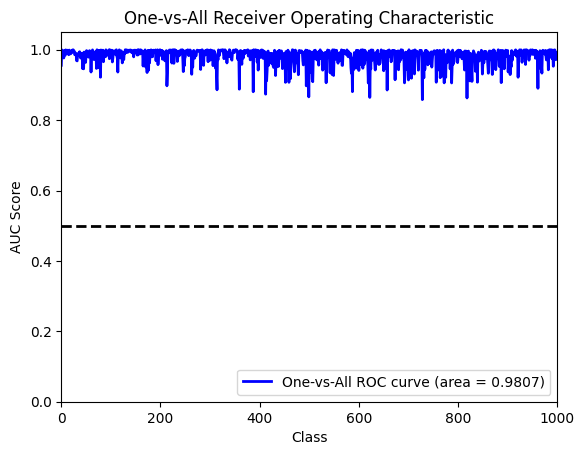

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-S statistic for 3: 0.48820
Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_attack/defocus_blur/3_ResNet50/ResNet50_3_metrics.txt
Using: cuda


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:59<00:00, 166.84it/s]


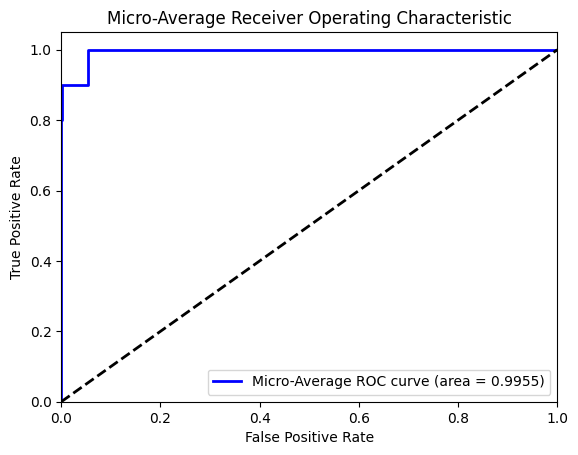

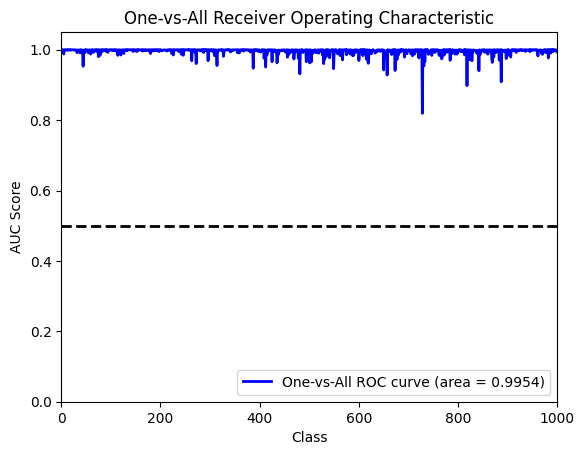

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-S statistic for 1: 0.13840
Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_attack/pixelate/1_ResNet50/ResNet50_1_metrics.txt
Using: cuda


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [00:59<00:00, 167.80it/s]


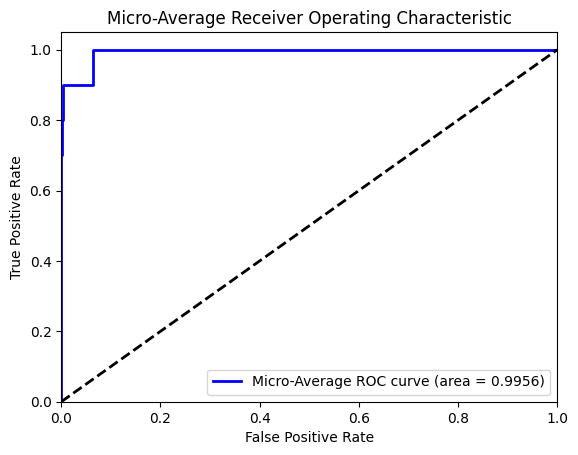

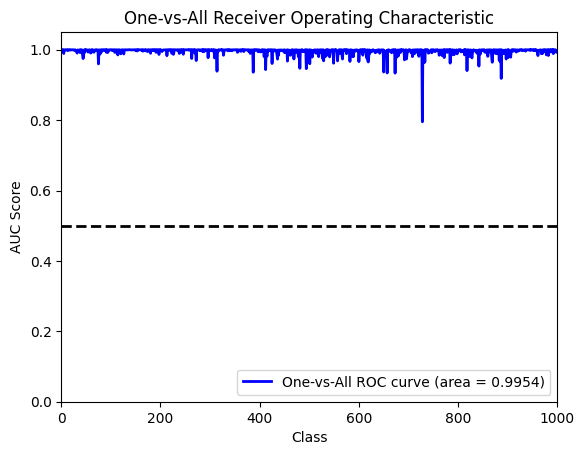

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-S statistic for 2: 0.14130
Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_attack/pixelate/2_ResNet50/ResNet50_2_metrics.txt
Using: cuda


/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [01:00<00:00, 164.70it/s]


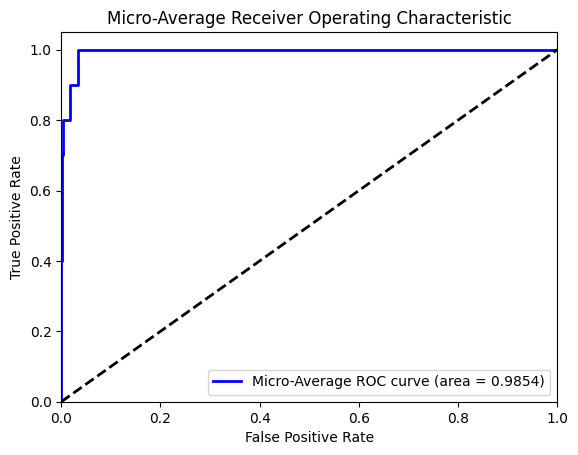

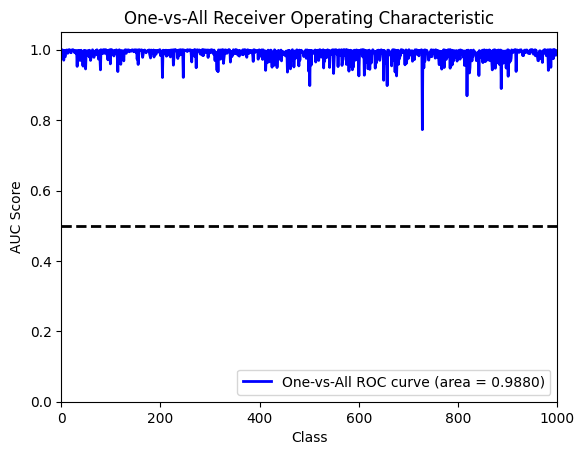

/home/z/miniconda3/envs/xai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-S statistic for 3: 0.31700
Metrics saved to /home/z/Music/code/CAIN/imagenet/val_images10k_attack/pixelate/3_ResNet50/ResNet50_3_metrics.txt


In [1]:
import os
from PIL import Image
import json
from torchvision.models import resnet50
from torchvision import transforms
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
import shutil  
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import json
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np
from scipy.stats import ks_2samp 
def calculate_ks_statistic(distribution1, distribution2):
    ks_statistic, p_value = ks_2samp(distribution1, distribution2)
    return ks_statistic
# Function to load images
def load_images_from_directory(root_path: str):
    dataset = []
    for label in os.listdir(root_path):
        label_path = os.path.join(root_path, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = Image.open(image_path)
                    dataset.append((img, label, image_file))
    return dataset
def ensure_rgb(img):
    if img.mode != 'RGB':
        return img.convert('RGB')
    return img
current_dir = "/home/z/Music/code/CAIN"
#dataset_path = f"{current_dir}/imagenet/val_images10k"

dataset_paths = [
    f"{current_dir}/imagenet/val_images10k",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/1",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/2",
    f"{current_dir}/imagenet/val_images10k_attack/gaussian_noise/3",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/1",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/2",
    f"{current_dir}/imagenet/val_images10k_attack/defocus_blur/3", 
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/1",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/2",
    f"{current_dir}/imagenet/val_images10k_attack/pixelate/3",
]

original_dataset_probs = None
# for dataset_path in dataset_paths: 部分
for dataset_path in dataset_paths:
    dataset = load_images_from_directory(dataset_path)

    with open(f"{current_dir}/imagenet/imagenet_class_index.json", "r") as f:
        imagenet_class_index = json.load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using:", device)

    label_to_index_description = {v[0]: (k, v[1]) for k, v in imagenet_class_index.items()}

    model = resnet50(pretrained=True).to(device)
    model.eval()
    model_name = "ResNet50"

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])

    true_labels = []
    predicted_labels = []
    predicted_probs = []

    target_dir = dataset_path + "_" + model_name
    os.makedirs(target_dir, exist_ok=True)
    num_classes = 1000

    for img, label, filename in tqdm(dataset):
        img = ensure_rgb(img)
        img_tensor = transform(img).to(device)

        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0))
            probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]

        index_str, _ = label_to_index_description.get(label, (None, None))
        if index_str is None:
            continue
        true_label = int(index_str)
        true_labels.append(true_label)
        predicted_labels.append(np.argmax(probabilities))
        predicted_probs.append(probabilities)

    true_labels_binary = label_binarize(true_labels, classes=range(num_classes))
    predicted_probs = np.array(predicted_probs)

    fpr, tpr, _ = roc_curve(true_labels_binary.ravel(), predicted_probs.ravel())
    roc_auc = auc(fpr, tpr)

    class_auc_scores = []
    for i in range(num_classes):
        true_binary = (np.array(true_labels) == i).astype(int)
        pred_probs = predicted_probs[:, i]
        fpr, tpr, _ = roc_curve(true_binary, pred_probs)
        auc_score = auc(fpr, tpr)
        class_auc_scores.append(auc_score)
    roc_auc_one_vs_rest = np.mean(class_auc_scores)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='Micro-Average ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-Average Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    plt.plot(range(num_classes), class_auc_scores, color='blue', lw=2, label='One-vs-All ROC curve (area = {0:0.4f})'.format(roc_auc_one_vs_rest))
    plt.plot([0, num_classes], [0.5, 0.5], 'k--', lw=2)
    plt.xlim([0, num_classes])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Class')
    plt.ylabel('AUC Score')
    plt.title('One-vs-All Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')

    cm = confusion_matrix(true_labels, predicted_labels)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)

    dataset_name = os.path.basename(dataset_path)
    metrics_filename = f"{model_name}_{dataset_name}_metrics.txt"
    metrics_path = os.path.join(target_dir, metrics_filename)
    
    if dataset_path == dataset_paths[0]:
        original_dataset_probs = [max(probs) for probs in predicted_probs]  # 选择最高的概率值
    else:
        # 对于攻击数据集
        attacked_dataset_probs = [max(probs) for probs in predicted_probs]
        ks_statistic = calculate_ks_statistic(original_dataset_probs, attacked_dataset_probs)
        print(f"K-S statistic for {os.path.basename(dataset_path)}: {ks_statistic:.5f}")

        # 将K-S值写入度量文件
        with open(metrics_path, "a") as f:
            f.write(f"K-S Statistic (vs original): {ks_statistic:.5f}\n")

    with open(metrics_path, "w") as f:
        f.write(f"Micro-Average AUC: {roc_auc:.5f}\n")
        f.write(f"One-vs-All Average AUC: {roc_auc_one_vs_rest:.5f}\n")
        f.write(f"Precision (macro-average): {precision:.5f}\n")
        f.write(f"Recall (macro-average): {recall:.5f}\n")
        f.write(f"F1 Score (macro-average): {f1_score:.5f}\n")
        f.write(f"True Positives (per class): {tp.tolist()}\n")
        f.write(f"False Positives (per class): {fp.tolist()}\n")
        f.write(f"False Negatives (per class): {fn.tolist()}\n")
        f.write(f"True Negatives (per class): {tn.tolist()}\n")

    print(f"Metrics saved to {metrics_path}")
